In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('MNRAS')
from scipy import linalg
from scipy.interpolate import interp1d

In [2]:
## make the fake data

lam = [20, 30, 45, 60, 1000]
z_data = [0.2, 0.35, 0.5, 0.65]
z_sim = [0.3, 0.4, 0.5]

for iz in range(3):
    
    redshift = z_sim[iz]
    
    if redshift == 0.3: z_str = '0p300'
    if redshift == 0.4: z_str = '0p400'
    if redshift == 0.5: z_str = '0p500'
    
    data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
    data_loc += f'z{z_str}/model_hod000000/obs_q180_desy1/'
    rp_rad, DS, DS_err = np.loadtxt(f'../../hod/y1/data/y1_DS_bin_z_0.2_0.35_lam_20_30.dat', unpack=True)
    
    #### lesing data ####
    DS_data = []
    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_lam_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data.extend(np.exp(DS_interp(np.log(rp_rad))))
    DS_data = np.array(DS_data)
    
    #### lensing cov ####
    cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'

    
    for ilam in range(4):    
        rp_cov = np.loadtxt(cov_loc + f'rp_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        print('check radius difference', '%.2g'%max(abs(rp_cov[4:]/rp_rad - 1)))
        data = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        data = data[4:,4:]
        if ilam == 0:
            cov_DS = data * 1.
        else:
            cov_DS = linalg.block_diag(cov_DS, data)
    print('np.shape(cov_DS)', np.shape(cov_DS))
    cov_DS_inv = linalg.inv(cov_DS)
    
    
    #### counts data ####
    x, x, NC_data = np.loadtxt(data_loc+'abundance.dat',unpack=True)
    
    #### counts cov ####
    cov_NC = []
    for ilam in range(4):    
        counts, sv, bias, lnM_mean = np.loadtxt(cov_loc + f'counts_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        cov_NC.append(counts + sv)
    cov_NC = np.diag(cov_NC)
    cov_NC_inv = linalg.inv(cov_NC)
    
    
    #### combine counts and lensing 
    data_vec = np.append(NC_data, DS_data)
    from scipy.linalg import block_diag
    cov = block_diag(cov_NC, cov_DS)
    cov_inv = block_diag(cov_NC_inv, cov_DS_inv)
    
    print('np.shape(cov_inv)', np.shape(cov_inv))
    
    np.savetxt(f'data_vector_abacus_summit/data_vector_z{redshift}.dat', data_vec)
    np.savetxt(f'data_vector_abacus_summit/cov_inv_z{redshift}.dat', cov_inv)
    np.savetxt(f'data_vector_abacus_summit/cov_z{redshift}.dat', cov)

check radius difference 0.029
check radius difference 0.029
check radius difference 0.029
check radius difference 0.029
np.shape(cov_DS) (44, 44)
np.shape(cov_inv) (48, 48)
check radius difference 0.035
check radius difference 0.035
check radius difference 0.035
check radius difference 0.035
np.shape(cov_DS) (44, 44)
np.shape(cov_inv) (48, 48)
check radius difference 0.04
check radius difference 0.04
check radius difference 0.04
check radius difference 0.04
np.shape(cov_DS) (44, 44)
np.shape(cov_inv) (48, 48)


In [3]:
# # check radius!
# rp_rad = np.loadtxt(f'/projects/hywu/cluster_sims/cluster_finding/data/emulator_train/train/rp_rad.dat')

# rp_cov = np.loadtxt(cov_loc + 'rp_hiMpc_0.35_0.5_60_1000.dat')[:,2] * a / h
# print((rp_cov[4:] - rp_rad)/rp_rad) #okay!

frac noise: DS [0.11015452 0.10183059 0.09911385 0.10136696 0.11787409 0.14208075
 0.15099971 0.14314606 0.13182744 0.12735559 0.13658023]
frac noise: DS [0.11168102 0.09897539 0.09258357 0.09030422 0.09765518 0.11484916
 0.12938321 0.13298271 0.13051756 0.13088763 0.14239057]
frac noise: DS [0.14199774 0.12091451 0.10904346 0.10268636 0.10570311 0.12162374
 0.14140742 0.15435557 0.16092749 0.16859256 0.18656593]
frac noise: DS [0.11105128 0.08999828 0.07757886 0.07024456 0.06877261 0.07645296
 0.09148296 0.10667473 0.11799642 0.12945158 0.14996636]
frac noise: NC [0.0175447  0.03118481 0.06686312 0.11222373]
frac noise: DS [0.1447176  0.13379042 0.13024878 0.1333025  0.15535421 0.18853329
 0.20431955 0.20364925 0.20825756 0.2363194  0.30248112]
frac noise: DS [0.15180035 0.13453898 0.12587713 0.12286317 0.13315764 0.15766254
 0.18109002 0.19558688 0.21279717 0.24984728 0.32335538]
frac noise: DS [0.20017949 0.17046845 0.15376478 0.14490049 0.14948551 0.17316074
 0.20524743 0.23533197 

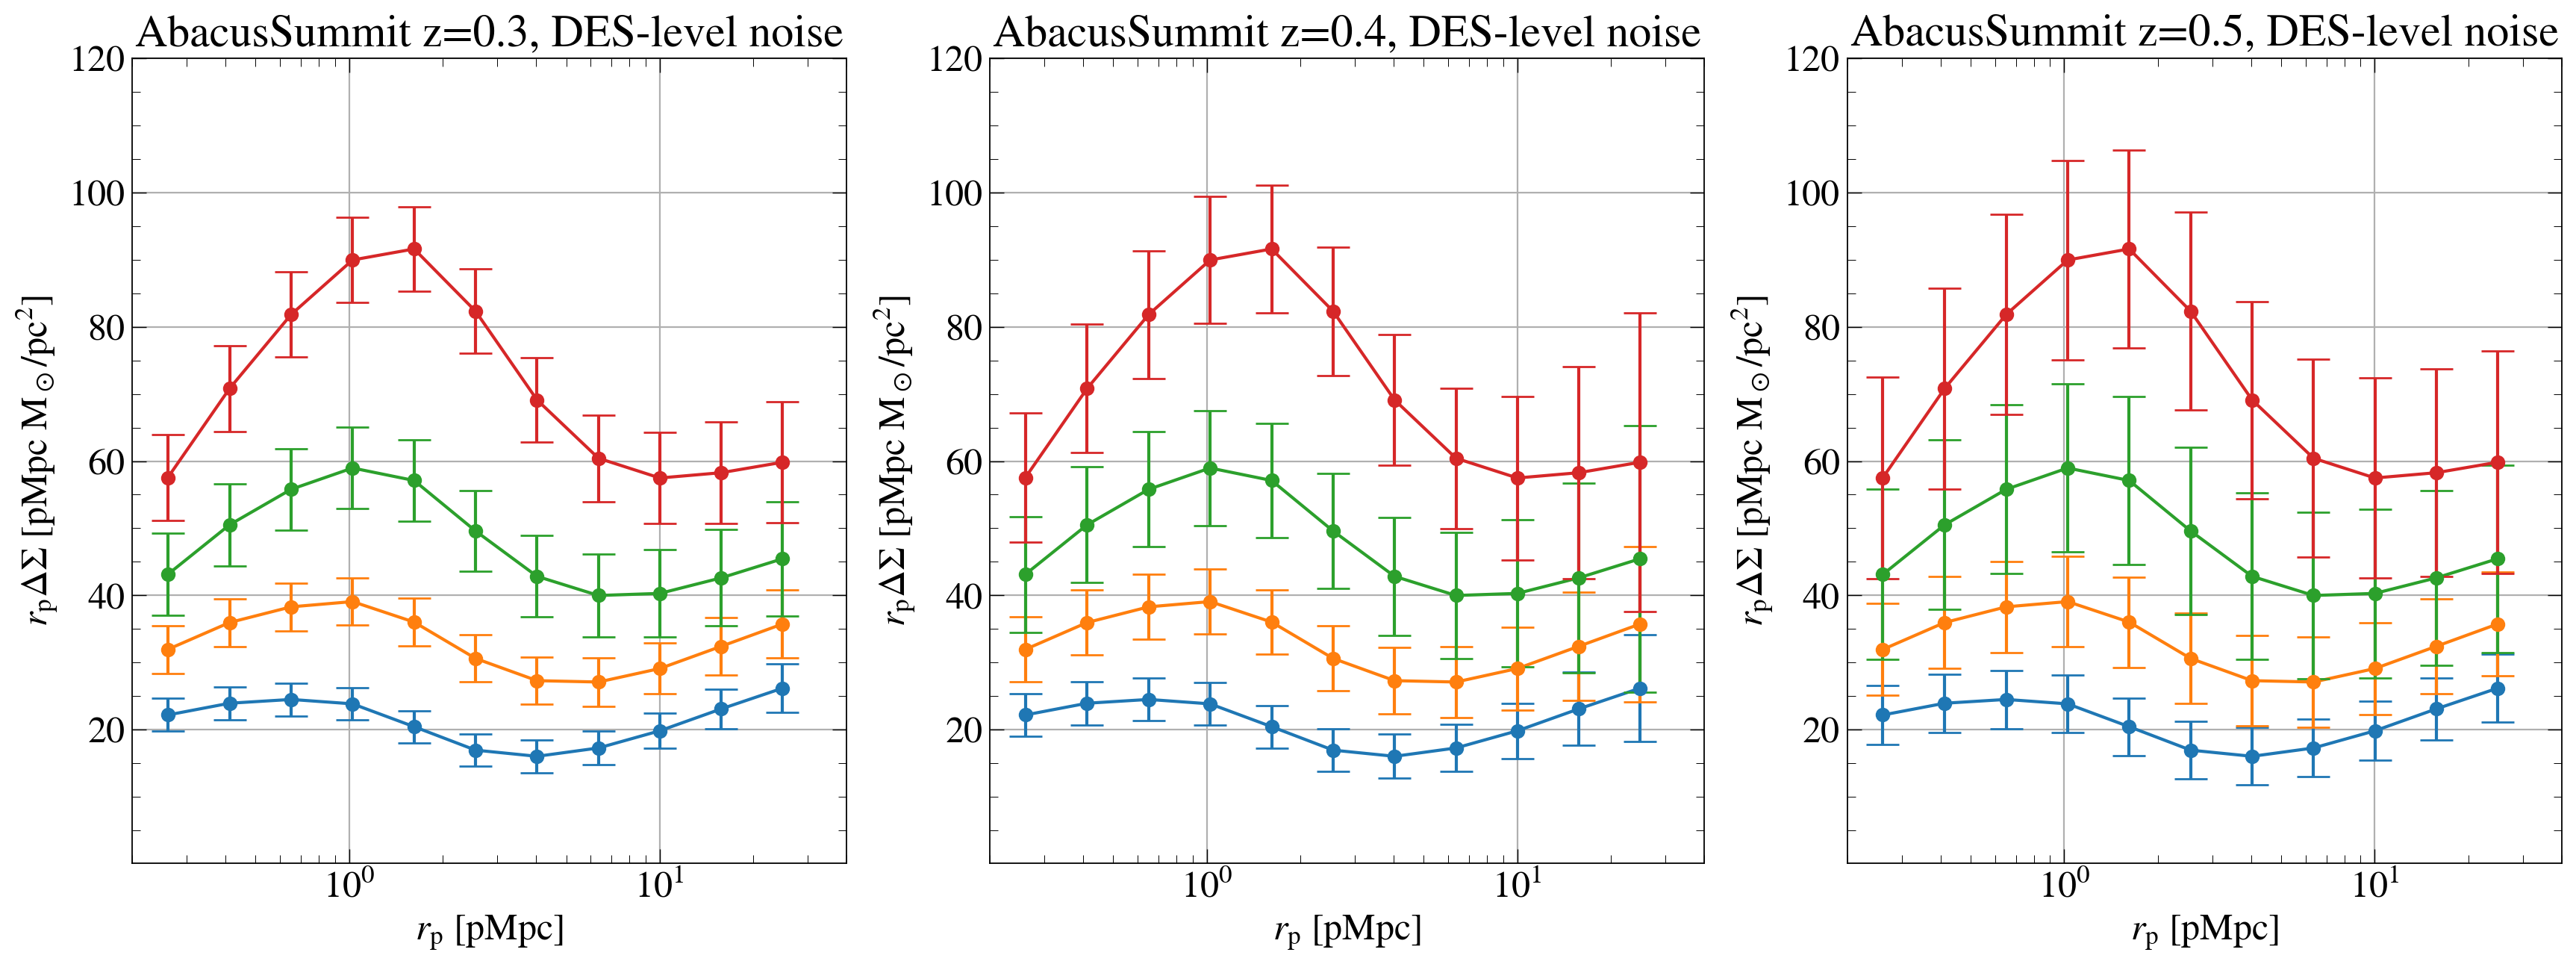

In [4]:
# plot the fake data and error bars
plt.figure(figsize=(21,7))
cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'
for iz in range(3):
    plt.subplot(1,3,1+iz)
    redshift = z_sim[iz]

    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_lam_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data = np.exp(DS_interp(np.log(rp_rad)))
    
        cov = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        sig = np.sqrt(np.diag(cov))[4:]
        line = plt.plot(rp_rad, rp_rad*DS_data)
        co = line[0].get_c()
        plt.errorbar(rp_rad, rp_rad*DS_data, rp_rad*sig, 
                     label='data', c=co, marker='o', mec=co, ls='', capsize=8)#, np.diag(cov))
        plt.xscale('log')
        print('frac noise: DS', sig/DS_data)
    
    plt.xlim(0.2, 40)
    plt.ylim(0.10, 120)
    plt.title(f'AbacusSummit z={redshift}, DES-level noise')
    
    plt.xlabel(r'$r_{\rm p}~[{\rm pMpc}]$')
    plt.ylabel(r'$r_{\rm p} \Delta\Sigma~[{\rm pMpc ~M_\odot/pc^2} ]$')
    sig_NC = np.sqrt(np.diag(cov_NC))
    print('frac noise: NC',sig_NC/NC_data)
plt.savefig(f'../../plots/emulator/abacus_summit_fid_lensing.pdf')